# Imports

In [1]:
import os
import time
import datetime
import pickle
import random
from datetime import datetime

import numpy as np
import pandas as pd

from scipy.stats import yulesimon

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

import tensorflow as tf

import keras
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import backend as K
from keras import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization, Conv1D, Flatten
from keras.optimizers import Adam, SGD
from keras.regularizers import l1, l2, l1_l2
from keras.metrics import mean_squared_error

# fix random seed for reproducability
RANDOM_STATE = 17
def fix_random(seed):
    os.environ['PYTONHASHSEED'] = '0'
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
fix_random(seed=RANDOM_STATE)


# Generate data
### &nbsp;&nbsp; *num_alphas*: number of alphas generated between (min_alpha) and (max_alpha) inclusive
### &nbsp;&nbsp; *samples_per_alpha*: number of samples (rows) for each alpha 
### &nbsp;&nbsp; *N* : number of random variates (number of samples drawn from yulesimon distribution)
### &nbsp;&nbsp; *M* : maximun value of random variates (length of input vectors == number of features)

In [2]:
def generate_data(num_alphas, samples_per_alpha, N, min_alpha=2.01, max_alpha=3.00, random_state=0):
    '''
    params:
        num_alphas: number of alphas generated between (min_alpha) and (max_alpha) inclusive
        samples_per_alpha: number of samples (rows) for each alpha 
        N: number of RV samples (columns) per row
    '''

    # fix loc at zero
    loc = 0

    X = np.empty((num_alphas * samples_per_alpha, N+1), float)

    row = 0
    for alpha in np.linspace(min_alpha, max_alpha, num=num_alphas):
        
        # generate samples (rows) for current alpha
        for i in range(samples_per_alpha):
            X[row, 0] = alpha
            X[row, 1:] = yulesimon.rvs(alpha, loc=loc, size=N, random_state=random_state)
            row += 1

    #lilo
    # suffle rows
    np.random.shuffle(X)

    # separate X from y
    y = X[:, 0]
    X = X[:, 1:].astype(int)

    # create a histogram (H) from (X) rows
    nbins = np.max(X)
    H = np.apply_along_axis(lambda a: np.histogram(a, bins=nbins, density=False)[0], 1, X)

    # log scale (H) rows
    logH = np.apply_along_axis(lambda a: np.log10(a+1), 1, H)

    return logH, y, nbins # (nbins == M)

# Create Model

In [3]:
def create_model(n_features, 
                 layers, 
                 activation='relu', 
                 init='he_uniform', 
                 batch_normalization=False, 
                 dropout=0, 
                 optimizer='adam', 
                 k_reg=False, 
                 k_reg_lr=0.001, 
                 a_reg=False, 
                 a_reg_lr=0.001):

    model = Sequential()
    model.add(Conv1D(32, 2, activation="relu", input_shape=(n_features,1)))
    model.add(Flatten())
    model.add(Dense(64, activation="relu"))
    model.add(Dense(1))
    model.compile(loss="mse", optimizer="adam")

    return model


# Training

In [4]:
def train(X_train, y_train, X_val, y_val, layers=[256, 256], batch_size=32):
    model = create_model(X_train.shape[1], 
                         layers=layers, 
                         activation='relu', 
                         init=keras.initializers.HeUniform(seed=RANDOM_STATE), 
                         batch_normalization=True, 
                         dropout=0.0, 
                         optimizer=Adam(lr=1e-2), 
                         #optimizer=SGD(lr=1e-3, momentum=0.9, decay=0.01), 
                         k_reg=True, 
                         k_reg_lr=1e-5, 
                         a_reg=True, 
                         a_reg_lr=1e-5)
    
    # early-stopping
    es_patience = 50
    es = EarlyStopping(monitor='val_loss', 
                        patience=es_patience, 
                        mode='min', 
                        restore_best_weights=True, 
                        verbose=0)
    
    # model checkpoint
    if not os.path.exists('models'):
        os.makedirs('models')
    date_str = datetime.now().strftime('%d-%m-%Y_%H-%M-%S')
    base_path       = 'models/yulesimon_{}'.format(date_str)
    model_path      = '{}.h5'.format(base_path)
    history_path    = '{}.history'.format(base_path)
    
    cp = ModelCheckpoint(filepath=model_path, monitor='val_loss', mode='min', save_best_only=True, verbose=0)
    
    # reduce learning-rate on plateau
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.95, patience=10)
    
    # fit model
    history = model.fit(X_train, 
                        y_train, 
                        validation_data=(X_val, y_val), 
                        epochs=200, 
                        batch_size=batch_size, 
                        shuffle=False, 
                        callbacks=[es, reduce_lr, cp], 
                        verbose=0)
    
    # save history with model
    with open(history_path, 'wb') as f:
        pickle.dump(history.history, f)
    
    # load best weights from last checkpoint
    model = keras.models.load_model(model_path)
    return model, history.history

In [5]:
def plot_learning_curves(history, train_key='loss', val_key='val_loss'):
    plt.figure(figsize=(2,2))
    plt.plot(history[train_key])
    plt.plot(history[val_key])
    plt.title('learning curves')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()
    print('loss:', np.min(history['loss']))
    print('val_loss:', np.min(history['val_loss']))    

# Trials

In [6]:
def _trial(num_alphas, samples_per_alpha, N, layers=[256, 256], batch_size=32, verbose=True):
    
    X, y, M = generate_data(
        num_alphas=num_alphas, 
        samples_per_alpha=samples_per_alpha, 
        N=N, 
        random_state=RANDOM_STATE)

    # reshape X for Conv1D
    X = X.reshape(X.shape[0], X.shape[1], 1)
    #lilo:print('reshape X:', X.shape)

    # split train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
        test_size=0.2, random_state=RANDOM_STATE)

    # split train/val
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
        test_size=0.25, random_state=RANDOM_STATE)

    # training
    model, history = train(X_train, y_train, X_val, y_val, layers=None)

    # predict
    y_pred = model.predict(X_test).flatten()

    #lilo
    # evaluate
    # print(model.evaluate(X_train, y_train))
    # print("MSE: %.4f" % mean_squared_error(y_test, y_pred))

    mse = mean_squared_error(y_test, y_pred)
    return np.sqrt(mse), model, history, M

In [7]:
# x_ax = range(len(y_pred))
# plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
# plt.plot(x_ax, y_pred, lw=0.8, color="red", label="predicted")
# plt.legend()
# plt.show()


In [8]:
RANDOM_STATE = 4

print('Processing...')
print()

x = np.array([])
y = np.array([])

for i in range(3,16):

    N = 2**i  
    
    sqrt_mse, m, h, M = _trial(
        num_alphas=100, 
        samples_per_alpha=100, 
        N=N, 
        layers='auto', 
        batch_size=32, 
        verbose=False)

    x = np.append(x, N)
    y = np.append(y, sqrt_mse)
    # print('N = {}, M = {} => sqrt(mse) = {:.3f}'.format(N, M, sqrt_mse))
    print('N = {}, M = {} => sqrt(mse) = {}'.format(N, M, sqrt_mse))


Processing...

N = 8, M = 6 => sqrt(mse) = 0.06356669962406158
N = 16, M = 6 => sqrt(mse) = 0.08449089527130127
N = 32, M = 4 => sqrt(mse) = 0.10465949773788452
N = 64, M = 14 => sqrt(mse) = 0.023330485448241234
N = 128, M = 30 => sqrt(mse) = 0.011209946125745773
N = 256, M = 14 => sqrt(mse) = 0.013737095519900322
N = 512, M = 107 => sqrt(mse) = 0.003571560140699148
N = 1024, M = 32 => sqrt(mse) = 0.004778565838932991
N = 2048, M = 46 => sqrt(mse) = 0.0026588814798742533
N = 4096, M = 65 => sqrt(mse) = 0.002080752281472087
N = 8192, M = 206 => sqrt(mse) = 0.0015623715007677674
N = 16384, M = 170 => sqrt(mse) = 0.00012212866568006575
N = 32768, M = 1691 => sqrt(mse) = 9.319696232523711e-07


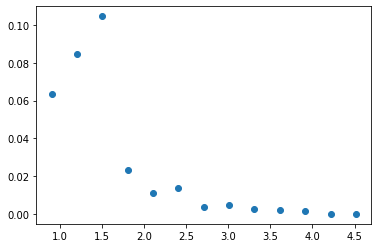

In [9]:
# plot log(N) vs sqrt_mse
_ = plt.scatter(np.log10(x), y)

In [10]:
RANDOM_STATE = 20

print('Processing...')
print()

x2 = np.array([])
y2 = np.array([])

for i in range(3,16):

    N = 2**i  
    
    sqrt_mse2, m2, h2, M2 = _trial(
        num_alphas=100, 
        samples_per_alpha=100, 
        N=N, 
        layers='auto', 
        batch_size=32, 
        verbose=False)

    x2 = np.append(x2, N)
    y2 = np.append(y2, sqrt_mse2)
    print('N = {}, M = {} => sqrt(mse) = {}'.format(N, M2, sqrt_mse2))


Processing...

N = 8, M = 3 => sqrt(mse) = 0.09104426950216293
N = 16, M = 5 => sqrt(mse) = 0.0682622641324997
N = 32, M = 6 => sqrt(mse) = 0.07052530348300934
N = 64, M = 18 => sqrt(mse) = 0.022500861436128616
N = 128, M = 32 => sqrt(mse) = 0.01054348610341549
N = 256, M = 71 => sqrt(mse) = 0.004775390960276127
N = 512, M = 69 => sqrt(mse) = 0.0049757398664951324
N = 1024, M = 57 => sqrt(mse) = 0.006063124164938927
N = 2048, M = 95 => sqrt(mse) = 0.0019479023758322
N = 4096, M = 260 => sqrt(mse) = 0.0013969657011330128
N = 8192, M = 108 => sqrt(mse) = 0.0005329098203219473
N = 16384, M = 220 => sqrt(mse) = 0.0014553647488355637
N = 32768, M = 121 => sqrt(mse) = 0.0005909721949137747


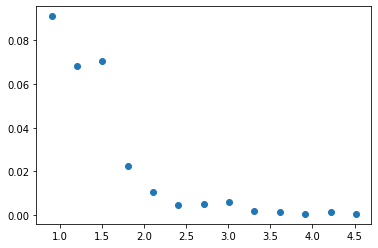

In [11]:
_ = plt.scatter(np.log10(x2), y2)

In [12]:
RANDOM_STATE = 17

print('Processing...')
print()

x3 = np.array([])
y3 = np.array([])

for i in range(3,16):

    N = 2**i  
    
    sqrt_mse3, m3, h3, M3 = _trial(
        num_alphas=100, 
        samples_per_alpha=100, 
        N=N, 
        layers='auto', 
        batch_size=32, 
        verbose=False)

    x3 = np.append(x3, N)
    y3 = np.append(y3, sqrt_mse3)
    print('N = {}, M = {} => sqrt(mse) = {}'.format(N, M3, sqrt_mse3))


Processing...

N = 8, M = 4 => sqrt(mse) = 0.27556928992271423
N = 16, M = 3 => sqrt(mse) = 0.14832790195941925
N = 32, M = 14 => sqrt(mse) = 0.04014796391129494
N = 64, M = 11 => sqrt(mse) = 0.03135155886411667
N = 128, M = 101 => sqrt(mse) = 0.014233757741749287
N = 256, M = 23 => sqrt(mse) = 0.010556573048233986
N = 512, M = 32 => sqrt(mse) = 0.006898629479110241
N = 1024, M = 48 => sqrt(mse) = 0.0036429590545594692
N = 2048, M = 65 => sqrt(mse) = 0.0055571673437952995
N = 4096, M = 72 => sqrt(mse) = 0.0053411079570651054
N = 8192, M = 88 => sqrt(mse) = 0.0006801022682338953
N = 16384, M = 119 => sqrt(mse) = 0.00025582866510376334
N = 32768, M = 251 => sqrt(mse) = 1.8118242905984516e-07


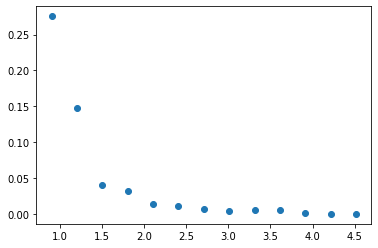

In [13]:
_ = plt.scatter(np.log10(x3), y3)

In [19]:
RANDOM_STATE = 0

print('Processing...')
print()

x4 = np.array([])
y4 = np.array([])

for i in range(3,16):

    N = 2**i  
    
    sqrt_mse4, m4, h4, M4 = _trial(
        num_alphas=100, 
        samples_per_alpha=100, 
        N=N, 
        layers='auto', 
        batch_size=8, 
        verbose=False)

    x4 = np.append(x4, N)
    y4 = np.append(y4, sqrt_mse4)
    print('N = {}, M = {} => sqrt(mse) = {}'.format(N, M4, sqrt_mse4))


Processing...

N = 8, M = 4 => sqrt(mse) = 0.13936364650726318
N = 16, M = 4 => sqrt(mse) = 0.06611090153455734
N = 32, M = 34 => sqrt(mse) = 0.04815435782074928
N = 64, M = 20 => sqrt(mse) = 0.012600624933838844
N = 128, M = 46 => sqrt(mse) = 0.014109806157648563
N = 256, M = 22 => sqrt(mse) = 0.006290253251791
N = 512, M = 33 => sqrt(mse) = 0.005581642035394907
N = 1024, M = 63 => sqrt(mse) = 0.004194810055196285
N = 2048, M = 142 => sqrt(mse) = 0.0039087701588869095
N = 4096, M = 483 => sqrt(mse) = 2.869949753403489e-07
N = 8192, M = 195 => sqrt(mse) = 6.688855501124635e-05
N = 16384, M = 253 => sqrt(mse) = 4.315639614560496e-07
N = 32768, M = 416 => sqrt(mse) = 3.065814235014841e-05


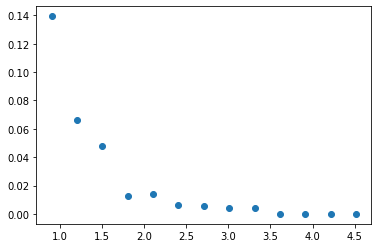

In [20]:
_ = plt.scatter(np.log10(x4), y4)